# Modeling Spotted Time Series with `starry`

## Creating spots at the pixel level

`starry`'s builting in `starry.Map.spot` function is a great way to add spots at arbitrary contrasts, radii, latitudes, and longitudes. However, this function has a number of limits that may or may not ultimately affect our end goal. One way to solve this would be to tune the different spot smoothing parameters for that function, but this is a bit difficult (and therefore ill-advised) to do. To circumvent this but still mitigate some of the issues, we can inject spots in pixel space, allowing us to make more spots that are smaller with smoother shapes without causing (too much, or as much) ringing (for more on what this means, see the ending of this tutorial: https://starry.readthedocs.io/en/latest/notebooks/StarSpots/) **at a much, much faster rate**.

This tutorial assumes that you have a basic understanding of `starry`, how to create surface maps and associated photometric and radial velocity curves, and some degree of how to transform those maps over time, and pixel space versus spherical harmonic basis. To keep things simple, we will assume that there are no occultor in our example (for now!).

In [291]:
%matplotlib inline

In [292]:
import numpy as np
import starry
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib import colors

starry.config.lazy = False
starry.config.quiet = True

Let's start by creating a basic `map` with some orientation but no spots. We'll want to set `rv=False` here but we'll change that later on when we need to calculate the RVs.

/opt/anaconda3/envs/starry/lib/python3.8/site-packages/starry/_plotting.py:63: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


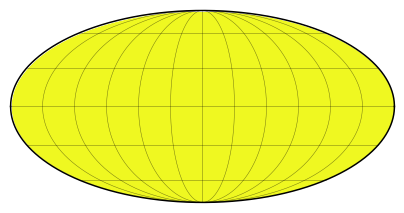

In [293]:
map = starry.Map(ydeg=20, udeg=1, rv=False)

map.inc = 87.5
map.obl = 2.5
prot = 10 # days
map.veq = 5.0 * 1e4 # m/s
map.alpha = 0.0
map[1] = 0.2

# Plotting parameters
cmap = plt.cm.get_cmap("plasma").copy()
cmap.set_under("#666666")
cmap.set_over("w")
cnorm = lambda: colors.Normalize(vmin=0.0)

map.show(projection="moll", norm=cnorm(), cmap=cmap)

Perfect. Now, let's create some spots. Like the `starry.Map.spot` function, we'll want to define our spots using the contrast, radius, and their position on the surface, i.e., latitude and longitude. Let's set some initial parameters for $N=5$ spots to start off.

In [294]:
spot_cons = [0.2, 0.3, 0.4, 0.5, 0.25]
spot_rads = [2.0, 2.0, 6.5, 9.5, 3.0]
spot_lats = [-67.0, -23.0, 5.2, 29.0, 50.0]
spot_lons = [0.0, -60.0, 120.0, 45.0, -30.0]

Now, in order to inject spots onto the pixel map, we need the pixel transformations of the map. We can use `map.get_pixel_transforms()` to get everything that will help us do that. For more information on what's going on here, see this tutorial: https://starry.readthedocs.io/en/latest/notebooks/PixelTransform/.

Then, we'll define a function that will inject our spots based on their parameter in pixel space before transforming back to the spherical harmonic basis.

In [295]:
lat, lon, Y2P, P2Y, Dx, Dy = map.get_pixel_transforms() # pixel transformations

p = Y2P.dot(map.y) # the "base" pixel map that we use

In [296]:
def angle_diff(lat, lon, spot_lat, spot_lon):
    """
    Calculate the angular difference between spot center and the rest of the (spherical) stellar surface.
    """
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    spot_lat, spot_lon = np.deg2rad(spot_lat), np.deg2rad(spot_lon)

    delta_lon = np.abs(lon - spot_lon)
    sines = np.sin(lat) * np.sin(spot_lat)
    cosines = np.cos(lat)*np.cos(spot_lat)*np.cos(delta_lon)

    return np.rad2deg(np.arccos(sines+cosines))

def spot_c(arc_length, spot_radius):
    """
    Treat the spot contrast radially from spot center, normalized by max contrast, as a Gaussian.
    """
    norm = stats.norm.pdf(0.0, 0.0, spot_radius)
    return stats.norm.pdf(arc_length, 0.0, spot_radius) / norm

def add_spot(p, spot_lats, spot_lons, spot_rads, spot_cons, lat, lon, N_spot=1):
    """
    Add N_spot number of spots onto a pixel map p using the lat and lon coordinates.
    spot_lats, spot_lons, spot_rads, spot_cons are arrays of length N_spot
    with the spot latitude, longitudes, radii, and contrasts.
    """
    
    p_i = p.copy()

    for s in range(N_spot):
        arc_length = angle_diff(lat, lon, spot_lats[s], spot_lons[s])
        p_i *= (1.0 - spot_cons[s]*spot_c(arc_length, spot_rads[s])) # reduce spot

    return p_i

Inject the spots using the new `add_spot` function, and transform back into spherical harmonics by dotting the `P2Y` matrix with the new `p` (pixel) vector.

/opt/anaconda3/envs/starry/lib/python3.8/site-packages/starry/_plotting.py:63: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


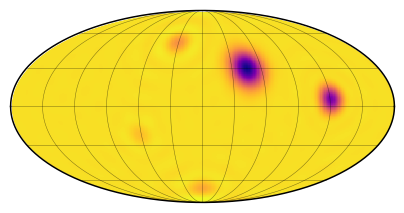

In [297]:
new_p = add_spot(p, spot_lats, spot_lons, spot_rads, spot_cons, lat, lon, N_spot=5)

new_y = P2Y.dot(new_p) # pixels

map[1:, :] = new_y[1:] / new_y[0]
map.amp = new_y[0]

map.show(projection="moll", cmap=cmap)

You can see that even with this method, the ringing is still present! These effects look more prominent in this image due to the normalization but the contribution of this ringing effect is likely on or below the level of expected photometric noise. Overall, this looks great!

## Have spots decay over time

Now we've set ourselves up to add an arbitrary amount of starspots to a `starry` map, let's add the ability for spots to emerge and decay over time. For now, we'll assume that the spot center does not move over time.

We'll have to give our 5 spots some initial "birth time", as well as a time (and theta!) array over which the star rotates and the spots emerge/decay. For convenience's sake, we'll assume that the star has a rotation period of 5 days, that we're observing it over 40 days at a rate of 1 obs/day, and the spots are at maximum contrast at halfway through our observations (`t=20` d).

To get extra fancy, we'll use `FuncAnimation` to animation the spot evolution over time!

In [298]:
def eta(r0, c0, t0, t, tau=0.1):
    """
    Exponetial decay function for spots. Contrast decays
    twice as fast as radius.

    ::Params::
    ==========
    c0 (float or array): initial contrast of spot
    r0 (float or array): initial radius of spot
    t0 (float or array): random choice for start of spot lifetime
    t (float): current timestep in star lifetime
    tau (int, optional):
        decay factor, arbitrarily defaults to 0.1,
        but there could be a more intelligent choice here?

    ::Returns::
    ===========
    r, c : float
        spot radius and contrast at timestep t
    """

    # calculate the time difference between the spot's maximum
    # contrast (t0) and current time (t), set to absolute
    # to account for user error and/or the set coming in vs. out
    delta_t = np.abs(t - t0)
    r, c = r0 * np.exp(-delta_t*tau), c0 * np.exp(-delta_t*tau*2.0)

    return r, c

In [299]:
t = np.arange(0, 41, 1)
theta = 360.0 / prot * t
spot_t = [20] * 5

In [300]:
res = 300
image = np.zeros((len(theta), res, res))

for i in range(len(theta)): # At every time step, change spots and then input them on the map.
    
    r, c = eta(spot_rads, spot_cons, spot_t, t[i])  # Change spots
    p_i = add_spot(p, spot_lats, spot_lons, r, c, N_spot=5,
                   lat=lat, lon=lon) # pixel-level surface map changes
    
    y_i = P2Y.dot(p_i)

    map[1:, :] = y_i[1:] / y_i[0]
    map.amp = y_i[0]
    
    image[i] = map.render(theta=theta[i], projection='moll')

In [301]:
def update(i):
    rot_map.set_array(image[i])
    images = [rot_map]
    return tuple(images)

fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
dx = 2.0 / image.shape[1]
extent = (-1 - dx, 1, -1 - dx, 1)

# plot the first image then update it in an animation
rot_map = ax.imshow(image[0], cmap="plasma", extent=extent, origin="lower",
                       vmin=np.nanmin(image), vmax=np.nanmax(image), zorder=-10)
plt.close() # add this in to make sure the first image doesn't show
ani = animation.FuncAnimation(fig, update, frames=len(t), interval=300, blit=True)

In [302]:
HTML(ani.to_html5_video())

Awesome! We can see that at around the halfway mark of the video, the spots have the highest contrast, as we've set! If you change the `projection` parameter in line 15 of block 267 to the default `"ortho"`, then you can see the rotation of the stellar map while the spots are decaying (although that's a lot harder to see without greatly increasing the time sampling, something like sampling every 3 hours might do it!). You can also see how changing the decay coefficient `tau` in the `eta` function affects this map!

# Rotate the star and calculate time series data

Now that we have a sense of what's going on, let's build on the previous example to start calculating time series data!